# Generative Adversarial Network (GAN) in TensorFlow

From the following technical blog __[Generative Adversarial Networks (GANs) in TensorFlow](https://github.com/uclaacmai/Generative-Adversarial-Network-Tutorial/blob/master/Generative%20Adversarial%20Networks%20Tutorial.ipynb)__. The data used here can be found at __[MNIST data](https://github.com/petewarden/tensorflow_makefile/blob/master/tensorflow/g3doc/tutorials/mnist/download/index.md)__

The basic idea of these networks is that you have 2 models, a generative model and a discriminative model. <img src="img/GAN1.png">

The discriminative model has the task of determining whether a given image looks natural (an image from the dataset) or looks like it has been artificially created. This is basically a binary classifier that will take the form of a normal convolutional neural network (CNN). The task of the generator is to create natural looking images that are similar to the original data distribution.

This can be thought of as a zero-sum or minimax two player game. The analogy used in the paper is that the generative model is like “a team of counterfeiters, trying to produce and use fake currency” while the discriminative model is like “the police, trying to detect the counterfeit currency”. The generator is trying to fool the discriminator while the discriminator is trying to not get fooled by the generator. As the models train through alternating optimization, both methods are improved until a point where the “counterfeits are indistinguishable from the genuine articles”. There are specific game theory concepts that prove there is indeed an equilibrium to this game where the generator gets so good that the discriminator outputs a probability of ½ for every input.

## 1 Import libraries

In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 2 Read the MNIST data

To do this, we’ll call a TF function called read_data_sets. This loads in the 55,000 training examples in the MNIST database.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The mnist variable we created above actually contains both the images and their labels. Let's just isolate the images for now. There will be 55,000 images and each of them will be of sixe 28 x 28.

In [25]:
x_train = mnist.train.images[:55000,:]
x_train.shape

(55000, 784)

Let's look at what a random image might look like.

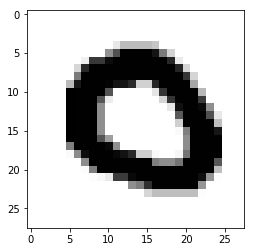

In [26]:
randomNum = random.randint(0,55000)
image = x_train[randomNum].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

## 3 Build the model step by step

### 3.1 The Discriminator Network

Let’s define a CNN classifier function that takes in an image (of size 28 x 28 x 1) as input. The output will be a single scalar number activation that describes whether or not the input image is real or not.
<img src="img/GAN2.png">

First, we define some functions that will help us with creating CNNs in Tensorflow

In [27]:
def conv2d(x, W):
  return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
  return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

We’ll start off by passing the image through a convolutional layer. First, we create our weight and bias variables through tf.get_variable. Our first weight matrix (or filter) will be of size 5x5 and will have a output depth of 8. It will be randomly initialized from a normal distribution.

Then, we’ll call the function tf.nn.conv2d() through a helper function called conv2d. tf.nn.conv2d() is the Tensorflow’s function for a common convolution. It takes in 4 arguments. The first is the input volume (our 28 x 28 x 1 image in this case). The next argument is the filter/weight matrix. Finally, you can also change the stride and padding of the convolution. Those two values affect the dimensions of the output volume.

As with any convolutional neural network, this module is repeated, and then followed by a series of fully connected layers. At the end of the network, we do a final matrix multiply and return the activation value. For those of you comfortable with CNNs, this is just a simple binary classifier. 

This architecture for this network is based on Tensorflow's sample CNN classifier model that they have explained in detail __[here](https://www.tensorflow.org/tutorials/mnist/pros/)__


In [28]:
def discriminator(x_image, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        #First Conv and Pool Layers
        W_conv1 = tf.get_variable('d_wconv1', [5, 5, 1, 8], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv1 = tf.get_variable('d_bconv1', [8], initializer=tf.constant_initializer(0))
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = avg_pool_2x2(h_conv1)

        #Second Conv and Pool Layers
        W_conv2 = tf.get_variable('d_wconv2', [5, 5, 8, 16], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv2 = tf.get_variable('d_bconv2', [16], initializer=tf.constant_initializer(0))
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = avg_pool_2x2(h_conv2)

        #First Fully Connected Layer
        W_fc1 = tf.get_variable('d_wfc1', [7 * 7 * 16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*16])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('d_wfc2', [32, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))

        #Final Layer
        y_conv=(tf.matmul(h_fc1, W_fc2) + b_fc2)
    return y_conv

### 3.2 The Generator Network

Now that we have our discriminator defined, let’s take a look at the generator module. For this, we’ll be basing our model off the generator introduced in the __[DCGAN paper](https://arxiv.org/pdf/1511.06434v2.pdf)__. You can think of the generator as being a kind of reverse ConvNet. With CNNs, the goal is to transform a 2 or 3 dimensional matrix of pixel values into a single probability. A generator, however, seeks to take a d-dimensional noise vector and upsample it to become a 28 x 28 image. This upsampling is done through a convolutional transpose (or deconvolution) layer. ReLUs and Batch Norm are then used to stabilize the outputs of each layer.

The structure of the generator is very similar to that of the discriminator, except we're calling the convolution transpose method, instead of the conv2d one.

The conv transpose + relu + batch norm pipeline is repeated 4 times so that the output volume grows larger and larger until a 28 x 28 x 1 image is formed.


In [29]:
def generator(z, batch_size, z_dim, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        g_dim = 64 #Number of filters of first layer of generator 
        c_dim = 1 #Color dimension of output (MNIST is grayscale, so c_dim = 1 for us)
        s = 28 #Output size of the image
        s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16) #We want to slowly upscale the image, so these values will help
                                                                  #make that change gradual.

        h0 = tf.reshape(z, [batch_size, s16+1, s16+1, 25])
        h0 = tf.nn.relu(h0)
        #Dimensions of h0 = batch_size x 2 x 2 x 25

        #First DeConv Layer
        output1_shape = [batch_size, s8, s8, g_dim*4]
        W_conv1 = tf.get_variable('g_wconv1', [5, 5, output1_shape[-1], int(h0.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv1
        H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, is_training=True, scope="g_bn1")
        H_conv1 = tf.nn.relu(H_conv1)
        #Dimensions of H_conv1 = batch_size x 3 x 3 x 256

        #Second DeConv Layer
        output2_shape = [batch_size, s4 - 1, s4 - 1, g_dim*2]
        W_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], int(H_conv1.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv2
        H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, is_training=True, scope="g_bn2")
        H_conv2 = tf.nn.relu(H_conv2)
        #Dimensions of H_conv2 = batch_size x 6 x 6 x 128

        #Third DeConv Layer
        output3_shape = [batch_size, s2 - 2, s2 - 2, g_dim*1]
        W_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], int(H_conv2.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv3
        H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, is_training=True, scope="g_bn3")
        H_conv3 = tf.nn.relu(H_conv3)
        #Dimensions of H_conv3 = batch_size x 12 x 12 x 64

        #Fourth DeConv Layer
        output4_shape = [batch_size, s, s, c_dim]
        W_conv4 = tf.get_variable('g_wconv4', [5, 5, output4_shape[-1], int(H_conv3.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, 
                                         strides=[1, 2, 2, 1], padding='VALID') + b_conv4
        H_conv4 = tf.nn.tanh(H_conv4)
        #Dimensions of H_conv4 = batch_size x 28 x 28 x 1

    return H_conv4

### 3.3 Generating a Sample Image

Now, we have defined both the generator and discriminator functions. Let’s see what a sample output from an untrained generator looks like. With Tensorflow, we need to first define a session and then create a placeholder for the input to our generator. The purpose of a placeholder is basically to tell Tensorflow "We're going to input in our random z vector later, but for now, we're going to define this placeholder variable instead". It lets Tensorflow know about the size of the inputs beforehand. The shape of the placeholder will be None x z_dimensions. The None keyword means that the value can be determined at session runtime. We normally have None as our first dimension so that we can have variable batch sizes (With a batch size of 16, the input to the generator would be 16 x 100). With the None keywoard, we don't have to specify batch_size until later.

In [30]:
sess = tf.Session()
z_dimensions = 100
z_test_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

Now, we create a variable (sample_image) that holds the output of the generator, and also initialize the random noise vector that we’ll use as input. The np.random.normal function has three arguments. The first and second define the range of the output distribution we want (between -1 and 1 in our case), and the third defines the the shape of the vector (1 x 100).

In [32]:
sample_image = generator(z_test_placeholder, 1, z_dimensions, True)
test_z = np.random.normal(-1, 1, [1,z_dimensions])

Next, we initialize all the variables, feed our test_z into the placeholder, and run the session. The sess.run function has two arguments. The first is called the "fetches" argument. It defines the value for you're interested in computing. For example, in our case, we want to see what the output of the generator is. If you look back at the last code snippet, the output of the generator function is stored in sample_image. Therefore, we'll use sample_image for our first argument. The second argument is where we input our feed_dict. This data structure is where we provide inputs to all of our placeholders. In our example, we need to feed our test_z variable into the z placeholder we defined earlier.

In [33]:
sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z}))

Finally, we can view the output through matplotlib.

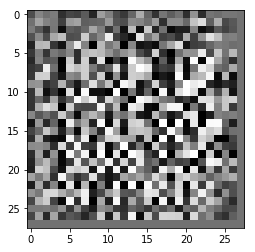

In [34]:
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')
plt.show()

Not a very convincing MNIST digit right? Let’s look at how we can make our generator better. Enter loss functions and optimization!

## 4 Training a GAN

In [35]:
batch_size = 16
tf.reset_default_graph() #Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph

sess = tf.Session()
x_placeholder = tf.placeholder("float", shape = [None,28,28,1]) #Placeholder for input images to the discriminator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions]) #Placeholder for input noise vectors to the generator

One of the trickiest parts about understanding GANs is that the loss function is a little bit more complex than that of a traditional CNN classifiers (For those, a simple MSE or Hinge Loss would do the trick). If you think back to the introduction, a GAN can be thought of as a zero sum minimax game. The generator is constantly improving to produce more and more realistic images, while the discriminator is trying to get better and better at distinguishing between real and generated images. This means that we need to formulate loss functions that affect both networks. Let’s take a look at the inputs and outputs of our networks.

In [36]:
Dx = discriminator(x_placeholder) #Dx will hold discriminator prediction probabilities for the real MNIST images
Gz = generator(z_placeholder, batch_size, z_dimensions) #Gz holds the generated images
Dg = discriminator(Gz, reuse=True) #Dg will hold discriminator prediction probabilities for generated images



So, let’s first think about what we want out of our networks. We want the generator network to create images that will fool the discriminator. The generator wants the discriminator to output a 1 (positive example). Therefore, we want to compute the loss between the Dg and label of 1. This can be done through the tf.nn.sigmoid_cross_entropy_with_logits function. This means that the cross entropy loss will be taken between the two arguments. The "with_logits" component means that the function will operate on unscaled values. Basically, this means that instead of using a softmax function to squish the output activations to probability values from 0 to 1, we simply return the unscaled value of the matrix multiplication. Take a look at the last line of our discriminator. There's no softmax or sigmoid layer at the end.

The reduce mean function just takes the mean value of all of the components in the matrixx returned by the cross entropy function. This is just a way of reducing the loss to a single scalar value, instead of a vector or matrix.


In [37]:
# ensure forward compatibility: function needs to have logits and labels args explicitly used
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg))) 

Now, let’s think about the discriminator’s point of view. Its goal is to just get the correct labels (output 1 for each MNIST digit and 0 for the generated ones). We’d like to compute the loss between Dx and the correct label of 1 as well as the loss between Dg and the correct label of 0.

In [38]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

Once we have our 2 loss functions (d_loss and g_loss), we need to define our optimizers. Keep in mind that the optimizer for the generator network needs to only update the generator’s weights, not those of the discriminator. In order to make this distinction, we need to create 2 lists, one with the discriminator’s weights and one with the generator’s weights. This is where naming all of your Tensorflow variables can come in handy.

In [39]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

Next, we specify our two optimizers. In today’s era of deep learning, Adam seems to be the best SGD optimizer as it utilizes adaptive learning rates and momentum. We call Adam's minimize function and also specify the variables that we want it to update.

In [40]:
print(tf.get_variable_scope().reuse)
adam = tf.train.AdamOptimizer()
trainerD = adam.minimize(d_loss, var_list=d_vars)
trainerG = adam.minimize(g_loss, var_list=g_vars)

False


You can also specify a learning rate by passing it as an argument (I’ve found .0002 to be effective).

Ah, now the best part of neural networks, the famous training loop. During every iteration, there will be two updates being made, one to the discriminator and one to the generator. For the generator update, we’ll feed in a random z vector to the generator and pass that output to the discriminator to obtain a probability score (this is the Dg variable we specified earlier). As we remember from our loss function, the cross entropy loss gets minimized, and only the generator’s weights and biases get updated.

We'll do the same for the discriminator update. We’ll be taking a batch of images from the mnist variable we created way at the beginning of our program. These will serve as the positive examples, while the images in the previous section are the negative ones.


In [47]:
sess.run(tf.global_variables_initializer())
iterations = 10000
for i in range(iterations):
    if i % 1000 == 0:
        print("iteration=%d"%i)
    z_batch = np.random.normal(-1, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)
    real_image_batch = np.reshape(real_image_batch[0],[batch_size,28,28,1])
    _,dLoss = sess.run([trainerD, d_loss],feed_dict={z_placeholder:z_batch,x_placeholder:real_image_batch}) #Update the discriminator
    _,gLoss = sess.run([trainerG,g_loss],feed_dict={z_placeholder:z_batch}) #Update the generator
    
print("Done!")

iteration=0
iteration=1000
iteration=2000
iteration=3000
iteration=4000
iteration=5000
iteration=6000
iteration=7000
iteration=8000
iteration=9000
Done!


Let's now see what a sample image looks like after training.

<class 'tensorflow.python.framework.ops.Tensor'>


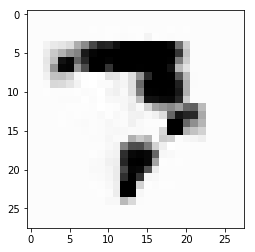

In [53]:
sample_image = generator(z_placeholder, 1, z_dimensions, True)
z_batch = np.random.normal(-1, 1, size=[1, z_dimensions])
temp = (sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')

## 5 Closing thoughts

### 5.1 Training Difficulties

One note that I’d like to make is that GANs are notoriously difficult to train. Without the right hyperparameters, network architecture, and training procedure, there is a high chance that either the generator or discriminator will overpower the other. A common case of this is the situation where the generator is able to find a flaw in the discriminator by repeatedly outputting an image that fits the data distribution the discriminator is looking for, but is nowhere close to being a readable MNIST digit. The generator has collapsed onto a single point, and therefore we won’t output a variety of digits. There are also cases where the discriminator becomes too powerful and is able to easily make the distinction between real and fake images.

The mathematical intuition behind this phenomenon lies in that GANs are typically trained using gradient descent techniques that are designed to find the minimum value of a cost function, rather than to find the Nash equilibrium of a game. When used to seek for a Nash equilibrium, these algorithms may fail to converge. Further research into game theory and stable optimization techniques may result in GANs that are as easy to train as ConvNets!

### 5.2 Other GAN implementations

In this post, we showed how two networks were able to play a minimax game in order to capture the data distribution of the MNIST digits and generate similar looking samples. With applications in video frame prediction, text-image mappings, and more, GANs are definitely the hottest topic in deep learning. Hopefully, with this tutorial, you’ve gained a better understanding of how these networks work in practice and how you can build your own with Tensorflow!

Some more great GAN implementations

__[DCGAN Tensorflow Implentation](https://github.com/carpedm20/DCGAN-tensorflow)__

__[Arthur Juliani's GAN Implementation](https://github.com/awjuliani/TF-Tutorials/blob/master/DCGAN.ipynb)__

__[Brandon Amos's Image Completion Project](https://bamos.github.io/2016/08/09/deep-completion/)__
